# 3. Compress the data

## 3.1 Compress model
We start with splitting the autoencoder model in a compress and a decode model. The compressing part consists of the first 8 layers (layer 0 - 7) of the autoencoder model.

In [1]:
from keras.models import load_model, Model
encode_end = 7

autoencoder = load_model("data/autoencoder.h5")
compress = Model(inputs=autoencoder.input, outputs=autoencoder.layers[encode_end].output)
compress.summary()
compress.save("data/compress.h5")

2022-06-11 11:21:48.494691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-11 11:21:48.494715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 16, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 16, 8)          1160  

2022-06-11 11:21:52.280540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-11 11:21:52.280563: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-11 11:21:52.280578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ai): /proc/driver/nvidia/version does not exist
2022-06-11 11:21:52.280776: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3.2 Decode model
For the decoded model we need to specify a new input layer, followed by the 7 last layers of the encoder model.

In [2]:
# start of decode layer
decode_start = encode_end + 1

# new input layer 
decode_config = autoencoder.get_config()
decode_config['layers'][0] = {'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 4, 8, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []}
# followed by the last layers of the autoencoder model
del decode_config['layers'][1:decode_start]
decode_config['layers'][1]['inbound_nodes']=[[['input_1', 0, 0, {}]]]
decode = Model.from_config(decode_config, custom_objects={})
weights = [layer.get_weights() for layer in autoencoder.layers[decode_start:]]
for layer, weight in zip(decode.layers[1:], weights):
    layer.set_weights(weight)

# print summary and save
decode.summary()
decode.save("data/decode.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 8, 1)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 8, 8)           80        
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 16, 8)         0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 16, 16)         1168      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 32, 32)        4640  

## 3.3 Testing the compress and decode model
The combination of the compress and the decode model should give the same output as the autoencoder model. 

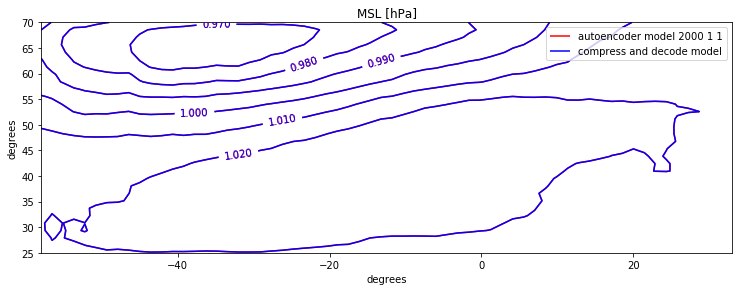

In [3]:
import numpy as np
from isoplot import isoplot
# set date "%Y %-m %-d"
date = "2000 1 1"
file="data/era20c.npy"

# load models
autoencoder = load_model("data/autoencoder.h5")
compress = load_model("data/compress.h5")
decode = load_model("data/decode.h5")

x = np.load(file)
dates = np.load("data/dates.npy")
zone = np.load("data/zone.npy")
scale = np.load("data/scale.npy")
date_index = np.where(dates == date)
x_in = x[date_index]

# compare output with input
x_out = autoencoder.predict(x_in) 
x_compressed = compress.predict(x_in)
x_decoded = decode.predict(x_compressed)
isoplot(x_out[0,:,:,0],x_decoded[0,:,:,0],"autoencoder model "+date,"compress and decode model",zone,scale[0])

## 3.4 Compressing the complete dataset
Now we can compress our section of the ERA-20C dataset.

In [4]:
x_compress = compress.predict(x)
np.save("data/era20c_compressed.npy", x_compress)

2022-06-11 11:21:56.657343: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 664240128 exceeds 10% of free system memory.
